<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/documentation/assets/SG_img/SG%20-%20Horizontal%20Glow.png'>

# Quantization Aware Training YoloNAS on Custom Dataset



**Background**: Our research team developed a new deep learning architecture that competes with YOLOv8 using our efficient AutoNAC algorithm.
The new model, named YoloNAS, incorporates quantization-aware RepVGG blocks into the model architecture to ensure compatibility with Post-Training Quantization, making it more flexible and usable for different hardware configurations.


In this tutorial, we will demonstrate how to fine-tune the small variant of the YoloNAS, YoloNAS_S on a custom dataset from Hugging Face hub.

0. Installations and dataset setup.
1. Initialize train and validation dataloaders.
2. Define training hyper-parameters.
3. Instantiate a pre-trained YoloNAS_S model and launch training.
4. Run prediction on a real world input.
5. Load the best checkpoint from 3., perform post-training quantization and quantization-aware training.


Prerequisites:
- QAT/PTQ tutorials: [classification notebook](https://github.com/Deci-AI/super-gradients/blob/master/tutorials/PTQ_and_QAT_for_classification.ipynb), [Thorough tutorial](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ptq_qat.md)
- Training object detection models in SG: [Transfer learning notebook](https://bit.ly/3SkMohx).

It is also recommended to see the QAT/PTQ [tutorial](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj125-xvIv_AhVZhP0HHWQnCZYQFnoECBYQAQ&url=https%3A%2F%2Fwww.nvidia.com%2Fen-us%2Fon-demand%2Fsession%2Fgtcspring21-s31653%2F&usg=AOvVaw1i_93iFvK5HJDm_5-SXyMN) from NVidia.

# Installations

In [1]:
!pip install -qq super-gradients==3.4.1 pytorch-quantization==2.1.2 datasets[vision]~=2.1 pandas~=2.0 --extra-index-url https://pypi.ngc.nvidia.com

# Dataset Setup

In [2]:
from datasets import load_dataset

dataset = load_dataset("cppe-5")

In [3]:
CLASS_NAMES = dataset["train"].features["objects"].feature["category"].names
NUM_CLASSES = len(CLASS_NAMES)

In [4]:
from tqdm import tqdm
import cv2
import numpy as np
import json
import os


def convert_hf_to_coco(dataset_split, output_images_directory, output_annotation_json):
    class_names = dataset["train"].features["objects"].feature["category"].names

    coco_annotation = {
        "images": [],
        "annotations": [],
        "categories": [{"supercategory": name, "name": name, "id": category_id} for category_id, name in enumerate(class_names)],
    }

    os.makedirs(output_images_directory, exist_ok=True)

    annotation_id = 1

    for sample in tqdm(dataset_split):
        image_id = sample["image_id"]
        image = np.array(sample["image"])

        objects = sample["objects"]
        areas = objects["area"]
        bboxes = objects["bbox"]  # XYWH
        category_ids = objects["category"]

        for object_area, object_bbox, object_category in zip(areas, bboxes, category_ids):
            coco_annotation["annotations"].append(
                {
                    "id": annotation_id,
                    "category_id": object_category,
                    "area": float(object_area),
                    "iscrowd": 0,
                    "image_id": image_id,
                    "bbox": list(map(int, object_bbox)),
                }
            )
            annotation_id += 1

        filename = f"{image_id}.jpg"
        output_image_path = os.path.join(output_images_directory, filename)
        cv2.imwrite(output_image_path, image[..., ::-1])  # RGB to BGR

        coco_annotation["images"].append({"file_name": filename, "height": image.shape[0], "width": image.shape[1], "id": image_id})

    with open(output_annotation_json, "w") as f:
        json.dump(coco_annotation, f)


convert_hf_to_coco(dataset["train"], "cppe-5-coco/images/train", "cppe-5-coco/train_annotations.coco.json")
convert_hf_to_coco(dataset["test"], "cppe-5-coco/images/valid", "cppe-5-coco/valid_annotations.coco.json")

100%|██████████| 29/29 [00:00<00:00, 31.22it/s]


# Setup train and validation datasets

Next, we instantiate torch DataLoader objects, one for training and one for validation which will be used for training our model.


In [5]:
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import (
    DetectionRandomAffine,
    DetectionHSV,
    DetectionHorizontalFlip,
    DetectionPaddedRescale,
    DetectionStandardize,
    DetectionTargetsFormatTransform,
)
from super_gradients.training.utils.collate_fn import DetectionCollateFN
from super_gradients.training.datasets.datasets_utils import worker_init_reset_seed

train_dataset_params = dict(
    data_dir="cppe-5-coco",
    images_dir="images/train",
    json_annotation_file="train_annotations.coco.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionRandomAffine(degrees=0.0, scales=(0.5, 1.5), shear=0.0, target_size=(640, 640), filter_box_candidates=False, border_value=128),
        DetectionHSV(prob=1.0, hgain=5, vgain=30, sgain=30),
        DetectionHorizontalFlip(prob=0.5),
        DetectionPaddedRescale(input_dim=(640, 640)),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

valid_dataset_params = dict(
    data_dir="cppe-5-coco",
    images_dir="images/valid",
    json_annotation_file="valid_annotations.coco.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

trainset = COCOFormatDetectionDataset(**train_dataset_params)
valset = COCOFormatDetectionDataset(**valid_dataset_params)

The console stream is logged into C:\Users\ekhve\sg_logs\console.log


[2023-11-21 09:26:30] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-11-21 09:26:33] WARNING - redirects.py - NOTE: Redirects are currently not supported in Windows or MacOs.
W1121 09:26:33.426600 18092 redirects.py:27] NOTE: Redirects are currently not supported in Windows or MacOs.
[2023-11-21 09:26:38] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.
W1121 09:26:38.978173 18092 env_sanity_check.py:31] Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.
Indexing dataset annotations:  64%|██████▍   | 640/1000 [00:00<00:00, 3185.10it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [6]:
from torch.utils.data import DataLoader

train_dataloader_params = {
    "shuffle": True,
    "batch_size": 16,
    "drop_last": True,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "worker_init_fn": worker_init_reset_seed,
    "num_workers": 4,
    "persistent_workers": True,
}

val_dataloader_params = {
    "shuffle": False,
    "batch_size": 32,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "worker_init_fn": worker_init_reset_seed,
    "num_workers": 4,
    "persistent_workers": True,
}

train_loader = DataLoader(trainset, **train_dataloader_params)
valid_loader = DataLoader(valset, **val_dataloader_params)

# Defining training hyperparameters

In [7]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    "warmup_initial_lr": 1e-6,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "zero_weight_decay_on_bias_and_bn": True,
    "lr_warmup_epochs": 3,
    "warmup_mode": "LinearEpochLRWarmup",
    "optimizer_params": {"weight_decay": 0.0001},
    "ema": True,
    "ema_params": {"beta": 25, "decay_type": "exp"},
    "max_epochs": 30,
    "mixed_precision": True,
    "loss": PPYoloELoss(use_static_assigner=False, num_classes=NUM_CLASSES, reg_max=16),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=NUM_CLASSES,
            normalize_targets=True,
            include_classwise_ap=True,
            class_names=CLASS_NAMES,
            post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300, nms_threshold=0.7),
        )
    ],
    "metric_to_watch": "mAP@0.50",
}

# Instantiate YoloNAS model and launch training

We instantiate a YoloNAS_S model, pre-trained on the [COCO detection dataset](https://cocodataset.org/#home).
Notice we specify num_classes which is different from the 80 classes of COCO, which results in replacing the classification branch of our model's head.

In [8]:
from super_gradients.training import Trainer
from super_gradients.common.object_names import Models
from super_gradients.training import models

trainer = Trainer(experiment_name="yolo_nas_s_cppe-5", ckpt_root_dir="experiments")
model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, pretrained_weights="coco")
trainer.train(model=model, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)

Indexing dataset annotations: 100%|██████████| 29/29 [00:00<00:00, 2223.47it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
The console stream is now moved to experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379/console_Nov21_09_26_40.txt


[2023-11-21 09:26:42] INFO - sg_trainer.py - Using EMA with params {'beta': 25, 'decay_type': 'exp'}
[2023-11-21 09:26:42] WARNING - ema.py - Parameter `decay` is not specified for EMA params. Please specify `decay` parameter explicitly in your config:
ema: True
ema_params: 
  decay: 0.9999
  decay_type: exp
  beta: 15
Will default to decay: 0.9999
In the next major release of SG this warning will become an error.
[2023-11-21 09:27:25] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1000       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.3942
│   ├── Ppyoloeloss/loss_iou = 0.5403
│   ├── Ppyoloeloss/loss_dfl = 0.6373
│   └── Ppyoloeloss/loss = 3.5718
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.4354
    ├── Ppyoloeloss/loss_iou = 0.5028
    ├── Ppyoloeloss/loss_dfl = 0.5808
    ├── Ppyoloeloss/loss = 3.519
    ├── Precision@0.50 = 0.0033
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0008
    ├── F1@0.50 = 0.0
    ├── Ap@0.50_coverall = 0.0032
    ├── Ap@0.50_face_shield = 0.0
    ├── Ap@0.50_gloves = 0.0001
    ├── Ap@0.50_goggles = 0.0
    └── Ap@0.50_mask = 0.0005



Validating epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
[2023-11-21 09:28:36] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:28:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5655879974365234


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1419
│   │   ├── Epoch N-1      = 2.3942 (↘ -1.2523)
│   │   └── Best until now = 2.3942 (↘ -1.2523)
│   ├── Ppyoloeloss/loss_iou = 0.5154
│   │   ├── Epoch N-1      = 0.5403 (↘ -0.0249)
│   │   └── Best until now = 0.5403 (↘ -0.0249)
│   ├── Ppyoloeloss/loss_dfl = 0.5827
│   │   ├── Epoch N-1      = 0.6373 (↘ -0.0546)
│   │   └── Best until now = 0.6373 (↘ -0.0546)
│   └── Ppyoloeloss/loss = 2.24
│       ├── Epoch N-1      = 3.5718 (↘ -1.3317)
│       └── Best until now = 3.5718 (↘ -1.3317)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0584
    │   ├── Epoch N-1      = 2.4354 (↘ -1.377)
    │   └── Best until now = 2.4354 (↘ -1.377)
    ├── Ppyoloeloss/loss_iou = 0.4629
    │   ├── Epoch N-1      = 0.5028 (↘ -0.04)
    │   └── Best until now = 0.5028 (↘ -0.04)
    ├── Ppyoloeloss/loss_dfl = 0.4926
    │   ├── Epoch N-1      = 0.5808 (↘ -0.0882)
    │   └── Best until now = 0.5808 (↘ -0.0882)
    ├── Ppyoloeloss/loss = 2.0

Validating epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9564
│   │   ├── Epoch N-1      = 1.1419 (↘ -0.1855)
│   │   └── Best until now = 1.1419 (↘ -0.1855)
│   ├── Ppyoloeloss/loss_iou = 0.5201
│   │   ├── Epoch N-1      = 0.5154 (↗ 0.0047)
│   │   └── Best until now = 0.5154 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.5696
│   │   ├── Epoch N-1      = 0.5827 (↘ -0.0131)
│   │   └── Best until now = 0.5827 (↘ -0.0131)
│   └── Ppyoloeloss/loss = 2.0462
│       ├── Epoch N-1      = 2.24   (↘ -0.1939)
│       └── Best until now = 2.24   (↘ -0.1939)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1701
    │   ├── Epoch N-1      = 1.0584 (↗ 0.1117)
    │   └── Best until now = 1.0584 (↗ 0.1117)
    ├── Ppyoloeloss/loss_iou = 0.5614
    │   ├── Epoch N-1      = 0.4629 (↗ 0.0986)
    │   └── Best until now = 0.4629 (↗ 0.0986)
    ├── Ppyoloeloss/loss_dfl = 0.5564
    │   ├── Epoch N-1      = 0.4926 (↗ 0.0638)
    │   └── Best until now = 0.4926 (↗ 0.0638)
    ├── Ppyoloeloss/loss = 2.2

Validating epoch 3: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
[2023-11-21 09:29:29] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:29:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7696985006332397


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9516
│   │   ├── Epoch N-1      = 0.9564 (↘ -0.0048)
│   │   └── Best until now = 0.9564 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.5362
│   │   ├── Epoch N-1      = 0.5201 (↗ 0.0161)
│   │   └── Best until now = 0.5154 (↗ 0.0208)
│   ├── Ppyoloeloss/loss_dfl = 0.5813
│   │   ├── Epoch N-1      = 0.5696 (↗ 0.0117)
│   │   └── Best until now = 0.5696 (↗ 0.0117)
│   └── Ppyoloeloss/loss = 2.0692
│       ├── Epoch N-1      = 2.0462 (↗ 0.023)
│       └── Best until now = 2.0462 (↗ 0.023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8703
    │   ├── Epoch N-1      = 1.1701 (↘ -0.2998)
    │   └── Best until now = 1.0584 (↘ -0.1881)
    ├── Ppyoloeloss/loss_iou = 0.444
    │   ├── Epoch N-1      = 0.5614 (↘ -0.1175)
    │   └── Best until now = 0.4629 (↘ -0.0189)
    ├── Ppyoloeloss/loss_dfl = 0.4745
    │   ├── Epoch N-1      = 0.5564 (↘ -0.0818)
    │   └── Best until now = 0.4926 (↘ -0.018)
    ├── Ppyoloeloss/loss = 1.788

Validating epoch 4: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
[2023-11-21 09:29:55] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:29:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8267017602920532


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9289
│   │   ├── Epoch N-1      = 0.9516 (↘ -0.0228)
│   │   └── Best until now = 0.9516 (↘ -0.0228)
│   ├── Ppyoloeloss/loss_iou = 0.5283
│   │   ├── Epoch N-1      = 0.5362 (↘ -0.0079)
│   │   └── Best until now = 0.5154 (↗ 0.0129)
│   ├── Ppyoloeloss/loss_dfl = 0.574
│   │   ├── Epoch N-1      = 0.5813 (↘ -0.0074)
│   │   └── Best until now = 0.5696 (↗ 0.0044)
│   └── Ppyoloeloss/loss = 2.0312
│       ├── Epoch N-1      = 2.0692 (↘ -0.038)
│       └── Best until now = 2.0462 (↘ -0.015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7656
    │   ├── Epoch N-1      = 0.8703 (↘ -0.1047)
    │   └── Best until now = 0.8703 (↘ -0.1047)
    ├── Ppyoloeloss/loss_iou = 0.4098
    │   ├── Epoch N-1      = 0.444  (↘ -0.0342)
    │   └── Best until now = 0.444  (↘ -0.0342)
    ├── Ppyoloeloss/loss_dfl = 0.4485
    │   ├── Epoch N-1      = 0.4745 (↘ -0.026)
    │   └── Best until now = 0.4745 (↘ -0.026)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 5: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
[2023-11-21 09:30:23] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:30:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8555534482002258


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9065
│   │   ├── Epoch N-1      = 0.9289 (↘ -0.0224)
│   │   └── Best until now = 0.9289 (↘ -0.0224)
│   ├── Ppyoloeloss/loss_iou = 0.5176
│   │   ├── Epoch N-1      = 0.5283 (↘ -0.0108)
│   │   └── Best until now = 0.5154 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.563
│   │   ├── Epoch N-1      = 0.574  (↘ -0.011)
│   │   └── Best until now = 0.5696 (↘ -0.0066)
│   └── Ppyoloeloss/loss = 1.987
│       ├── Epoch N-1      = 2.0312 (↘ -0.0442)
│       └── Best until now = 2.0312 (↘ -0.0442)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7502
    │   ├── Epoch N-1      = 0.7656 (↘ -0.0154)
    │   └── Best until now = 0.7656 (↘ -0.0154)
    ├── Ppyoloeloss/loss_iou = 0.3969
    │   ├── Epoch N-1      = 0.4098 (↘ -0.0129)
    │   └── Best until now = 0.4098 (↘ -0.0129)
    ├── Ppyoloeloss/loss_dfl = 0.4422
    │   ├── Epoch N-1      = 0.4485 (↘ -0.0062)
    │   └── Best until now = 0.4485 (↘ -0.0062)
    ├── Ppyoloeloss/loss =

Validating epoch 6: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
[2023-11-21 09:30:50] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:30:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8584954142570496


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8851
│   │   ├── Epoch N-1      = 0.9065 (↘ -0.0213)
│   │   └── Best until now = 0.9065 (↘ -0.0213)
│   ├── Ppyoloeloss/loss_iou = 0.5121
│   │   ├── Epoch N-1      = 0.5176 (↘ -0.0054)
│   │   └── Best until now = 0.5154 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.5577
│   │   ├── Epoch N-1      = 0.563  (↘ -0.0053)
│   │   └── Best until now = 0.563  (↘ -0.0053)
│   └── Ppyoloeloss/loss = 1.955
│       ├── Epoch N-1      = 1.987  (↘ -0.032)
│       └── Best until now = 1.987  (↘ -0.032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7481
    │   ├── Epoch N-1      = 0.7502 (↘ -0.0022)
    │   └── Best until now = 0.7502 (↘ -0.0022)
    ├── Ppyoloeloss/loss_iou = 0.391
    │   ├── Epoch N-1      = 0.3969 (↘ -0.0058)
    │   └── Best until now = 0.3969 (↘ -0.0058)
    ├── Ppyoloeloss/loss_dfl = 0.4364
    │   ├── Epoch N-1      = 0.4422 (↘ -0.0059)
    │   └── Best until now = 0.4422 (↘ -0.0059)
    ├── Ppyoloeloss/loss =

Validating epoch 7: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]
[2023-11-21 09:31:18] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:31:18] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8650903701782227


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8657
│   │   ├── Epoch N-1      = 0.8851 (↘ -0.0195)
│   │   └── Best until now = 0.8851 (↘ -0.0195)
│   ├── Ppyoloeloss/loss_iou = 0.5035
│   │   ├── Epoch N-1      = 0.5121 (↘ -0.0086)
│   │   └── Best until now = 0.5121 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.5494
│   │   ├── Epoch N-1      = 0.5577 (↘ -0.0083)
│   │   └── Best until now = 0.5577 (↘ -0.0083)
│   └── Ppyoloeloss/loss = 1.9186
│       ├── Epoch N-1      = 1.955  (↘ -0.0364)
│       └── Best until now = 1.955  (↘ -0.0364)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7452
    │   ├── Epoch N-1      = 0.7481 (↘ -0.0029)
    │   └── Best until now = 0.7481 (↘ -0.0029)
    ├── Ppyoloeloss/loss_iou = 0.3889
    │   ├── Epoch N-1      = 0.391  (↘ -0.0022)
    │   └── Best until now = 0.391  (↘ -0.0022)
    ├── Ppyoloeloss/loss_dfl = 0.4345
    │   ├── Epoch N-1      = 0.4364 (↘ -0.0018)
    │   └── Best until now = 0.4364 (↘ -0.0018)
    ├── Ppyoloeloss/lo

Validating epoch 8: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
[2023-11-21 09:31:46] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:31:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8689987063407898


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8594
│   │   ├── Epoch N-1      = 0.8657 (↘ -0.0062)
│   │   └── Best until now = 0.8657 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.5034
│   │   ├── Epoch N-1      = 0.5035 (↘ -1e-04)
│   │   └── Best until now = 0.5035 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.5431
│   │   ├── Epoch N-1      = 0.5494 (↘ -0.0063)
│   │   └── Best until now = 0.5494 (↘ -0.0063)
│   └── Ppyoloeloss/loss = 1.9059
│       ├── Epoch N-1      = 1.9186 (↘ -0.0126)
│       └── Best until now = 1.9186 (↘ -0.0126)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7374
    │   ├── Epoch N-1      = 0.7452 (↘ -0.0078)
    │   └── Best until now = 0.7452 (↘ -0.0078)
    ├── Ppyoloeloss/loss_iou = 0.3858
    │   ├── Epoch N-1      = 0.3889 (↘ -0.0031)
    │   └── Best until now = 0.3889 (↘ -0.0031)
    ├── Ppyoloeloss/loss_dfl = 0.4325
    │   ├── Epoch N-1      = 0.4345 (↘ -0.002)
    │   └── Best until now = 0.4345 (↘ -0.002)
    ├── Ppyoloeloss/loss =

Validating epoch 9: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
[2023-11-21 09:32:14] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:32:14] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8728233575820923


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8472
│   │   ├── Epoch N-1      = 0.8594 (↘ -0.0122)
│   │   └── Best until now = 0.8594 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.4957
│   │   ├── Epoch N-1      = 0.5034 (↘ -0.0077)
│   │   └── Best until now = 0.5034 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_dfl = 0.5422
│   │   ├── Epoch N-1      = 0.5431 (↘ -0.001)
│   │   └── Best until now = 0.5431 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.8851
│       ├── Epoch N-1      = 1.9059 (↘ -0.0209)
│       └── Best until now = 1.9059 (↘ -0.0209)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7366
    │   ├── Epoch N-1      = 0.7374 (↘ -0.0008)
    │   └── Best until now = 0.7374 (↘ -0.0008)
    ├── Ppyoloeloss/loss_iou = 0.3852
    │   ├── Epoch N-1      = 0.3858 (↘ -0.0006)
    │   └── Best until now = 0.3858 (↘ -0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.433
    │   ├── Epoch N-1      = 0.4325 (↗ 0.0005)
    │   └── Best until now = 0.4325 (↗ 0.0005)
    ├── Ppyoloeloss/loss = 

Validating epoch 10: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]
[2023-11-21 09:32:45] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:32:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8754091262817383


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8444
│   │   ├── Epoch N-1      = 0.8472 (↘ -0.0028)
│   │   └── Best until now = 0.8472 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_iou = 0.4932
│   │   ├── Epoch N-1      = 0.4957 (↘ -0.0025)
│   │   └── Best until now = 0.4957 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.5395
│   │   ├── Epoch N-1      = 0.5422 (↘ -0.0027)
│   │   └── Best until now = 0.5422 (↘ -0.0027)
│   └── Ppyoloeloss/loss = 1.8771
│       ├── Epoch N-1      = 1.8851 (↘ -0.008)
│       └── Best until now = 1.8851 (↘ -0.008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7353
    │   ├── Epoch N-1      = 0.7366 (↘ -0.0013)
    │   └── Best until now = 0.7366 (↘ -0.0013)
    ├── Ppyoloeloss/loss_iou = 0.385
    │   ├── Epoch N-1      = 0.3852 (↘ -1e-04)
    │   └── Best until now = 0.3852 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.4328
    │   ├── Epoch N-1      = 0.433  (↘ -0.0002)
    │   └── Best until now = 0.4325 (↗ 0.0003)
    ├── Ppyoloeloss/loss = 

Validating epoch 11: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8291
│   │   ├── Epoch N-1      = 0.8444 (↘ -0.0153)
│   │   └── Best until now = 0.8444 (↘ -0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.4872
│   │   ├── Epoch N-1      = 0.4932 (↘ -0.006)
│   │   └── Best until now = 0.4932 (↘ -0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.533
│   │   ├── Epoch N-1      = 0.5395 (↘ -0.0064)
│   │   └── Best until now = 0.5395 (↘ -0.0064)
│   └── Ppyoloeloss/loss = 1.8493
│       ├── Epoch N-1      = 1.8771 (↘ -0.0278)
│       └── Best until now = 1.8771 (↘ -0.0278)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7349
    │   ├── Epoch N-1      = 0.7353 (↘ -0.0004)
    │   └── Best until now = 0.7353 (↘ -0.0004)
    ├── Ppyoloeloss/loss_iou = 0.3851
    │   ├── Epoch N-1      = 0.385  (↗ 1e-04)
    │   └── Best until now = 0.385  (↗ 1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.4329
    │   ├── Epoch N-1      = 0.4328 (↗ 1e-04)
    │   └── Best until now = 0.4325 (↗ 0.0003)
    ├── Ppyoloeloss/loss = 1.55

Validating epoch 12: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]
[2023-11-21 09:33:44] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:33:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8760765194892883


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8155
│   │   ├── Epoch N-1      = 0.8291 (↘ -0.0135)
│   │   └── Best until now = 0.8291 (↘ -0.0135)
│   ├── Ppyoloeloss/loss_iou = 0.4813
│   │   ├── Epoch N-1      = 0.4872 (↘ -0.0059)
│   │   └── Best until now = 0.4872 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_dfl = 0.5194
│   │   ├── Epoch N-1      = 0.533  (↘ -0.0136)
│   │   └── Best until now = 0.533  (↘ -0.0136)
│   └── Ppyoloeloss/loss = 1.8162
│       ├── Epoch N-1      = 1.8493 (↘ -0.0331)
│       └── Best until now = 1.8493 (↘ -0.0331)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7341
    │   ├── Epoch N-1      = 0.7349 (↘ -0.0008)
    │   └── Best until now = 0.7349 (↘ -0.0008)
    ├── Ppyoloeloss/loss_iou = 0.3851
    │   ├── Epoch N-1      = 0.3851 (↘ -0.0)
    │   └── Best until now = 0.385  (↗ 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.4327
    │   ├── Epoch N-1      = 0.4329 (↘ -0.0002)
    │   └── Best until now = 0.4325 (↗ 0.0002)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 13: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]
[2023-11-21 09:34:12] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:34:12] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8773082494735718


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8014
│   │   ├── Epoch N-1      = 0.8155 (↘ -0.0141)
│   │   └── Best until now = 0.8155 (↘ -0.0141)
│   ├── Ppyoloeloss/loss_iou = 0.4678
│   │   ├── Epoch N-1      = 0.4813 (↘ -0.0135)
│   │   └── Best until now = 0.4813 (↘ -0.0135)
│   ├── Ppyoloeloss/loss_dfl = 0.5181
│   │   ├── Epoch N-1      = 0.5194 (↘ -0.0013)
│   │   └── Best until now = 0.5194 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.7874
│       ├── Epoch N-1      = 1.8162 (↘ -0.0288)
│       └── Best until now = 1.8162 (↘ -0.0288)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7342
    │   ├── Epoch N-1      = 0.7341 (↗ 1e-04)
    │   └── Best until now = 0.7341 (↗ 1e-04)
    ├── Ppyoloeloss/loss_iou = 0.3849
    │   ├── Epoch N-1      = 0.3851 (↘ -0.0002)
    │   └── Best until now = 0.385  (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.4326
    │   ├── Epoch N-1      = 0.4327 (↘ -1e-04)
    │   └── Best until now = 0.4325 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 14: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
[2023-11-21 09:34:40] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:34:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8782386779785156


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7852
│   │   ├── Epoch N-1      = 0.8014 (↘ -0.0162)
│   │   └── Best until now = 0.8014 (↘ -0.0162)
│   ├── Ppyoloeloss/loss_iou = 0.4643
│   │   ├── Epoch N-1      = 0.4678 (↘ -0.0035)
│   │   └── Best until now = 0.4678 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.5112
│   │   ├── Epoch N-1      = 0.5181 (↘ -0.0069)
│   │   └── Best until now = 0.5181 (↘ -0.0069)
│   └── Ppyoloeloss/loss = 1.7608
│       ├── Epoch N-1      = 1.7874 (↘ -0.0266)
│       └── Best until now = 1.7874 (↘ -0.0266)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7342
    │   ├── Epoch N-1      = 0.7342 (↗ 1e-04)
    │   └── Best until now = 0.7341 (↗ 1e-04)
    ├── Ppyoloeloss/loss_iou = 0.3851
    │   ├── Epoch N-1      = 0.3849 (↗ 0.0002)
    │   └── Best until now = 0.3849 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.4326
    │   ├── Epoch N-1      = 0.4326 (↗ 1e-04)
    │   └── Best until now = 0.4325 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.55

Validating epoch 15: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]
[2023-11-21 09:35:08] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:35:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8794315457344055


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7801
│   │   ├── Epoch N-1      = 0.7852 (↘ -0.0052)
│   │   └── Best until now = 0.7852 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.4533
│   │   ├── Epoch N-1      = 0.4643 (↘ -0.011)
│   │   └── Best until now = 0.4643 (↘ -0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.498
│   │   ├── Epoch N-1      = 0.5112 (↘ -0.0133)
│   │   └── Best until now = 0.5112 (↘ -0.0133)
│   └── Ppyoloeloss/loss = 1.7314
│       ├── Epoch N-1      = 1.7608 (↘ -0.0294)
│       └── Best until now = 1.7608 (↘ -0.0294)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7344
    │   ├── Epoch N-1      = 0.7342 (↗ 1e-04)
    │   └── Best until now = 0.7341 (↗ 0.0003)
    ├── Ppyoloeloss/loss_iou = 0.3849
    │   ├── Epoch N-1      = 0.3851 (↘ -0.0002)
    │   └── Best until now = 0.3849 (↘ -0.0)
    ├── Ppyoloeloss/loss_dfl = 0.4326
    │   ├── Epoch N-1      = 0.4326 (↘ -0.0)
    │   └── Best until now = 0.4325 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.5519
 

Validating epoch 16: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
[2023-11-21 09:35:37] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:35:37] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8808680772781372


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7749
│   │   ├── Epoch N-1      = 0.7801 (↘ -0.0052)
│   │   └── Best until now = 0.7801 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.4534
│   │   ├── Epoch N-1      = 0.4533 (↗ 1e-04)
│   │   └── Best until now = 0.4533 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.5031
│   │   ├── Epoch N-1      = 0.498  (↗ 0.0051)
│   │   └── Best until now = 0.498  (↗ 0.0051)
│   └── Ppyoloeloss/loss = 1.7313
│       ├── Epoch N-1      = 1.7314 (↘ -0.0)
│       └── Best until now = 1.7314 (↘ -0.0)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7345
    │   ├── Epoch N-1      = 0.7344 (↗ 0.0002)
    │   └── Best until now = 0.7341 (↗ 0.0004)
    ├── Ppyoloeloss/loss_iou = 0.3845
    │   ├── Epoch N-1      = 0.3849 (↘ -0.0004)
    │   └── Best until now = 0.3849 (↘ -0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.4323
    │   ├── Epoch N-1      = 0.4326 (↘ -0.0003)
    │   └── Best until now = 0.4325 (↘ -0.0002)
    ├── Ppyoloeloss/loss = 1.5513
 

Validating epoch 17: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
[2023-11-21 09:36:06] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:36:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8826120495796204


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7711
│   │   ├── Epoch N-1      = 0.7749 (↘ -0.0038)
│   │   └── Best until now = 0.7749 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.4503
│   │   ├── Epoch N-1      = 0.4534 (↘ -0.0031)
│   │   └── Best until now = 0.4533 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.501
│   │   ├── Epoch N-1      = 0.5031 (↘ -0.0021)
│   │   └── Best until now = 0.498  (↗ 0.0031)
│   └── Ppyoloeloss/loss = 1.7224
│       ├── Epoch N-1      = 1.7313 (↘ -0.0089)
│       └── Best until now = 1.7313 (↘ -0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7341
    │   ├── Epoch N-1      = 0.7345 (↘ -0.0004)
    │   └── Best until now = 0.7341 (↗ 0.0)
    ├── Ppyoloeloss/loss_iou = 0.3844
    │   ├── Epoch N-1      = 0.3845 (↘ -1e-04)
    │   └── Best until now = 0.3845 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.4323
    │   ├── Epoch N-1      = 0.4323 (↘ -0.0)
    │   └── Best until now = 0.4323 (↘ -0.0)
    ├── Ppyoloeloss/loss = 1.5508
  

Validating epoch 18: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]
[2023-11-21 09:36:35] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:36:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8848713636398315


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7642
│   │   ├── Epoch N-1      = 0.7711 (↘ -0.0068)
│   │   └── Best until now = 0.7711 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.4503
│   │   ├── Epoch N-1      = 0.4503 (↗ 0.0)
│   │   └── Best until now = 0.4503 (↗ 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.4973
│   │   ├── Epoch N-1      = 0.501  (↘ -0.0037)
│   │   └── Best until now = 0.498  (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.7119
│       ├── Epoch N-1      = 1.7224 (↘ -0.0106)
│       └── Best until now = 1.7224 (↘ -0.0106)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7335
    │   ├── Epoch N-1      = 0.7341 (↘ -0.0007)
    │   └── Best until now = 0.7341 (↘ -0.0007)
    ├── Ppyoloeloss/loss_iou = 0.3842
    │   ├── Epoch N-1      = 0.3844 (↘ -0.0002)
    │   └── Best until now = 0.3844 (↘ -0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.4322
    │   ├── Epoch N-1      = 0.4323 (↘ -1e-04)
    │   └── Best until now = 0.4323 (↘ -1e-04)
    ├── Ppyoloeloss/loss = 1.54

Validating epoch 19: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7471
│   │   ├── Epoch N-1      = 0.7642 (↘ -0.0171)
│   │   └── Best until now = 0.7642 (↘ -0.0171)
│   ├── Ppyoloeloss/loss_iou = 0.4329
│   │   ├── Epoch N-1      = 0.4503 (↘ -0.0175)
│   │   └── Best until now = 0.4503 (↘ -0.0174)
│   ├── Ppyoloeloss/loss_dfl = 0.481
│   │   ├── Epoch N-1      = 0.4973 (↘ -0.0163)
│   │   └── Best until now = 0.4973 (↘ -0.0163)
│   └── Ppyoloeloss/loss = 1.661
│       ├── Epoch N-1      = 1.7119 (↘ -0.0509)
│       └── Best until now = 1.7119 (↘ -0.0509)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7326
    │   ├── Epoch N-1      = 0.7335 (↘ -0.0008)
    │   └── Best until now = 0.7335 (↘ -0.0008)
    ├── Ppyoloeloss/loss_iou = 0.3839
    │   ├── Epoch N-1      = 0.3842 (↘ -0.0003)
    │   └── Best until now = 0.3842 (↘ -0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.4321
    │   ├── Epoch N-1      = 0.4322 (↘ -1e-04)
    │   └── Best until now = 0.4322 (↘ -1e-04)
    ├── Ppyoloeloss/loss 

Validating epoch 20: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7328
│   │   ├── Epoch N-1      = 0.7471 (↘ -0.0143)
│   │   └── Best until now = 0.7471 (↘ -0.0143)
│   ├── Ppyoloeloss/loss_iou = 0.4304
│   │   ├── Epoch N-1      = 0.4329 (↘ -0.0024)
│   │   └── Best until now = 0.4329 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.4765
│   │   ├── Epoch N-1      = 0.481  (↘ -0.0045)
│   │   └── Best until now = 0.481  (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.6397
│       ├── Epoch N-1      = 1.661  (↘ -0.0212)
│       └── Best until now = 1.661  (↘ -0.0212)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7322
    │   ├── Epoch N-1      = 0.7326 (↘ -0.0004)
    │   └── Best until now = 0.7326 (↘ -0.0004)
    ├── Ppyoloeloss/loss_iou = 0.3837
    │   ├── Epoch N-1      = 0.3839 (↘ -1e-04)
    │   └── Best until now = 0.3839 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.432
    │   ├── Epoch N-1      = 0.4321 (↘ -0.0)
    │   └── Best until now = 0.4321 (↘ -0.0)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 21: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7274
│   │   ├── Epoch N-1      = 0.7328 (↘ -0.0054)
│   │   └── Best until now = 0.7328 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.4285
│   │   ├── Epoch N-1      = 0.4304 (↘ -0.002)
│   │   └── Best until now = 0.4304 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.4734
│   │   ├── Epoch N-1      = 0.4765 (↘ -0.003)
│   │   └── Best until now = 0.4765 (↘ -0.003)
│   └── Ppyoloeloss/loss = 1.6293
│       ├── Epoch N-1      = 1.6397 (↘ -0.0104)
│       └── Best until now = 1.6397 (↘ -0.0104)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7322
    │   ├── Epoch N-1      = 0.7322 (↘ -0.0)
    │   └── Best until now = 0.7322 (↘ -0.0)
    ├── Ppyoloeloss/loss_iou = 0.3839
    │   ├── Epoch N-1      = 0.3837 (↗ 1e-04)
    │   └── Best until now = 0.3837 (↗ 1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.4322
    │   ├── Epoch N-1      = 0.432  (↗ 0.0002)
    │   └── Best until now = 0.432  (↗ 0.0002)
    ├── Ppyoloeloss/loss = 1.5483
   

Validating epoch 22: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
[2023-11-21 09:38:29] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:38:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8853166699409485


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7199
│   │   ├── Epoch N-1      = 0.7274 (↘ -0.0075)
│   │   └── Best until now = 0.7274 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.4234
│   │   ├── Epoch N-1      = 0.4285 (↘ -0.005)
│   │   └── Best until now = 0.4285 (↘ -0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.468
│   │   ├── Epoch N-1      = 0.4734 (↘ -0.0055)
│   │   └── Best until now = 0.4734 (↘ -0.0055)
│   └── Ppyoloeloss/loss = 1.6113
│       ├── Epoch N-1      = 1.6293 (↘ -0.018)
│       └── Best until now = 1.6293 (↘ -0.018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7319
    │   ├── Epoch N-1      = 0.7322 (↘ -0.0003)
    │   └── Best until now = 0.7322 (↘ -0.0003)
    ├── Ppyoloeloss/loss_iou = 0.3839
    │   ├── Epoch N-1      = 0.3839 (↗ 1e-04)
    │   └── Best until now = 0.3837 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.4323
    │   ├── Epoch N-1      = 0.4322 (↗ 1e-04)
    │   └── Best until now = 0.432  (↗ 0.0003)
    ├── Ppyoloeloss/loss = 1.548

Validating epoch 23: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
[2023-11-21 09:38:58] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:38:58] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8857955932617188


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7094
│   │   ├── Epoch N-1      = 0.7199 (↘ -0.0105)
│   │   └── Best until now = 0.7199 (↘ -0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.4137
│   │   ├── Epoch N-1      = 0.4234 (↘ -0.0097)
│   │   └── Best until now = 0.4234 (↘ -0.0097)
│   ├── Ppyoloeloss/loss_dfl = 0.4616
│   │   ├── Epoch N-1      = 0.468  (↘ -0.0064)
│   │   └── Best until now = 0.468  (↘ -0.0064)
│   └── Ppyoloeloss/loss = 1.5848
│       ├── Epoch N-1      = 1.6113 (↘ -0.0265)
│       └── Best until now = 1.6113 (↘ -0.0265)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7316
    │   ├── Epoch N-1      = 0.7319 (↘ -0.0003)
    │   └── Best until now = 0.7319 (↘ -0.0003)
    ├── Ppyoloeloss/loss_iou = 0.3837
    │   ├── Epoch N-1      = 0.3839 (↘ -0.0002)
    │   └── Best until now = 0.3837 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.4321
    │   ├── Epoch N-1      = 0.4323 (↘ -0.0002)
    │   └── Best until now = 0.432  (↗ 1e-04)
    ├── Ppyoloeloss/loss

Validating epoch 24: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
[2023-11-21 09:39:27] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:39:27] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8862581253051758


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6976
│   │   ├── Epoch N-1      = 0.7094 (↘ -0.0118)
│   │   └── Best until now = 0.7094 (↘ -0.0118)
│   ├── Ppyoloeloss/loss_iou = 0.4102
│   │   ├── Epoch N-1      = 0.4137 (↘ -0.0035)
│   │   └── Best until now = 0.4137 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.4595
│   │   ├── Epoch N-1      = 0.4616 (↘ -0.0021)
│   │   └── Best until now = 0.4616 (↘ -0.0021)
│   └── Ppyoloeloss/loss = 1.5673
│       ├── Epoch N-1      = 1.5848 (↘ -0.0174)
│       └── Best until now = 1.5848 (↘ -0.0174)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.731
    │   ├── Epoch N-1      = 0.7316 (↘ -0.0006)
    │   └── Best until now = 0.7316 (↘ -0.0006)
    ├── Ppyoloeloss/loss_iou = 0.384
    │   ├── Epoch N-1      = 0.3837 (↗ 0.0003)
    │   └── Best until now = 0.3837 (↗ 0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.4321
    │   ├── Epoch N-1      = 0.4321 (↗ 0.0)
    │   └── Best until now = 0.432  (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.54

Validating epoch 25: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6927
│   │   ├── Epoch N-1      = 0.6976 (↘ -0.0049)
│   │   └── Best until now = 0.6976 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.4068
│   │   ├── Epoch N-1      = 0.4102 (↘ -0.0034)
│   │   └── Best until now = 0.4102 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.4571
│   │   ├── Epoch N-1      = 0.4595 (↘ -0.0024)
│   │   └── Best until now = 0.4595 (↘ -0.0024)
│   └── Ppyoloeloss/loss = 1.5566
│       ├── Epoch N-1      = 1.5673 (↘ -0.0107)
│       └── Best until now = 1.5673 (↘ -0.0107)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7307
    │   ├── Epoch N-1      = 0.731  (↘ -0.0003)
    │   └── Best until now = 0.731  (↘ -0.0003)
    ├── Ppyoloeloss/loss_iou = 0.3835
    │   ├── Epoch N-1      = 0.384  (↘ -0.0004)
    │   └── Best until now = 0.3837 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.4314
    │   ├── Epoch N-1      = 0.4321 (↘ -0.0007)
    │   └── Best until now = 0.432  (↘ -0.0006)
    ├── Ppyoloeloss/lo

Validating epoch 26: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6853
│   │   ├── Epoch N-1      = 0.6927 (↘ -0.0074)
│   │   └── Best until now = 0.6927 (↘ -0.0074)
│   ├── Ppyoloeloss/loss_iou = 0.4025
│   │   ├── Epoch N-1      = 0.4068 (↘ -0.0043)
│   │   └── Best until now = 0.4068 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.45
│   │   ├── Epoch N-1      = 0.4571 (↘ -0.0071)
│   │   └── Best until now = 0.4571 (↘ -0.0071)
│   └── Ppyoloeloss/loss = 1.5378
│       ├── Epoch N-1      = 1.5566 (↘ -0.0188)
│       └── Best until now = 1.5566 (↘ -0.0188)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7304
    │   ├── Epoch N-1      = 0.7307 (↘ -0.0003)
    │   └── Best until now = 0.7307 (↘ -0.0003)
    ├── Ppyoloeloss/loss_iou = 0.3835
    │   ├── Epoch N-1      = 0.3835 (↘ -0.0)
    │   └── Best until now = 0.3835 (↘ -0.0)
    ├── Ppyoloeloss/loss_dfl = 0.4315
    │   ├── Epoch N-1      = 0.4314 (↗ 1e-04)
    │   └── Best until now = 0.4314 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.5454

Validating epoch 27: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
[2023-11-21 09:40:51] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:40:51] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8888098001480103


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6818
│   │   ├── Epoch N-1      = 0.6853 (↘ -0.0035)
│   │   └── Best until now = 0.6853 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.3989
│   │   ├── Epoch N-1      = 0.4025 (↘ -0.0037)
│   │   └── Best until now = 0.4025 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.4493
│   │   ├── Epoch N-1      = 0.45   (↘ -0.0007)
│   │   └── Best until now = 0.45   (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.5299
│       ├── Epoch N-1      = 1.5378 (↘ -0.0079)
│       └── Best until now = 1.5378 (↘ -0.0079)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7303
    │   ├── Epoch N-1      = 0.7304 (↘ -0.0)
    │   └── Best until now = 0.7304 (↘ -0.0)
    ├── Ppyoloeloss/loss_iou = 0.3837
    │   ├── Epoch N-1      = 0.3835 (↗ 0.0002)
    │   └── Best until now = 0.3835 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.4315
    │   ├── Epoch N-1      = 0.4315 (↘ -0.0)
    │   └── Best until now = 0.4314 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.5455


Validating epoch 28: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
[2023-11-21 09:41:19] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:41:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8888454437255859


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6733
│   │   ├── Epoch N-1      = 0.6818 (↘ -0.0084)
│   │   └── Best until now = 0.6818 (↘ -0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.3986
│   │   ├── Epoch N-1      = 0.3989 (↘ -0.0003)
│   │   └── Best until now = 0.3989 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.4494
│   │   ├── Epoch N-1      = 0.4493 (↗ 1e-04)
│   │   └── Best until now = 0.4493 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.5213
│       ├── Epoch N-1      = 1.5299 (↘ -0.0086)
│       └── Best until now = 1.5299 (↘ -0.0086)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7303
    │   ├── Epoch N-1      = 0.7303 (↘ -1e-04)
    │   └── Best until now = 0.7303 (↘ -1e-04)
    ├── Ppyoloeloss/loss_iou = 0.3838
    │   ├── Epoch N-1      = 0.3837 (↗ 1e-04)
    │   └── Best until now = 0.3835 (↗ 0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.4316
    │   ├── Epoch N-1      = 0.4315 (↗ 1e-04)
    │   └── Best until now = 0.4314 (↗ 0.0002)
    ├── Ppyoloeloss/loss = 1.5457

Validating epoch 29: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]
[2023-11-21 09:41:48] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth
[2023-11-21 09:41:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8897334933280945


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6706
│   │   ├── Epoch N-1      = 0.6733 (↘ -0.0027)
│   │   └── Best until now = 0.6733 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.3968
│   │   ├── Epoch N-1      = 0.3986 (↘ -0.0018)
│   │   └── Best until now = 0.3986 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.4503
│   │   ├── Epoch N-1      = 0.4494 (↗ 0.0009)
│   │   └── Best until now = 0.4493 (↗ 0.001)
│   └── Ppyoloeloss/loss = 1.5177
│       ├── Epoch N-1      = 1.5213 (↘ -0.0036)
│       └── Best until now = 1.5213 (↘ -0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.73
    │   ├── Epoch N-1      = 0.7303 (↘ -0.0003)
    │   └── Best until now = 0.7303 (↘ -0.0003)
    ├── Ppyoloeloss/loss_iou = 0.384
    │   ├── Epoch N-1      = 0.3838 (↗ 0.0002)
    │   └── Best until now = 0.3835 (↗ 0.0005)
    ├── Ppyoloeloss/loss_dfl = 0.4317
    │   ├── Epoch N-1      = 0.4316 (↗ 1e-04)
    │   └── Best until now = 0.4314 (↗ 0.0003)
    ├── Ppyoloeloss/loss = 1.545

[2023-11-21 09:41:52] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 30:   0%|          | 0/1 [00:00<?, ?it/s]


# Step 4: Run prediction on a real world input.

Now, lets see our trained model in action. We load the best checkpoint from step 3, and simply call predict on a real-world image.

In [9]:
model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))
regular_metrics = trainer.test(model=model, test_loader=valid_loader)
regular_metrics

Validating epoch 30: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]
[2023-11-21 09:41:54] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2023-11-21 09:41:55] INFO - checkpoint_utils.py - Successfully loaded model weights from experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth EMA checkpoint.
Testing:   0%|          | 0/1 [00:00<?, ?it/s]

{'PPYoloELoss/loss_cls': 0.72997534,
 'PPYoloELoss/loss_iou': 0.38398942,
 'PPYoloELoss/loss_dfl': 0.4317493,
 'PPYoloELoss/loss': 1.5457141,
 'Precision@0.50': 0.13682515919208527,
 'Recall@0.50': 0.9488736391067505,
 'mAP@0.50': 0.8897334933280945,
 'F1@0.50': 0.23470160365104675,
 'AP@0.50_Coverall': 0.9260706305503845,
 'AP@0.50_Face_Shield': 1.0,
 'AP@0.50_Gloves': 0.8261978030204773,
 'AP@0.50_Goggles': 0.7970434427261353,
 'AP@0.50_Mask': 0.8993554711341858}

Testing: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


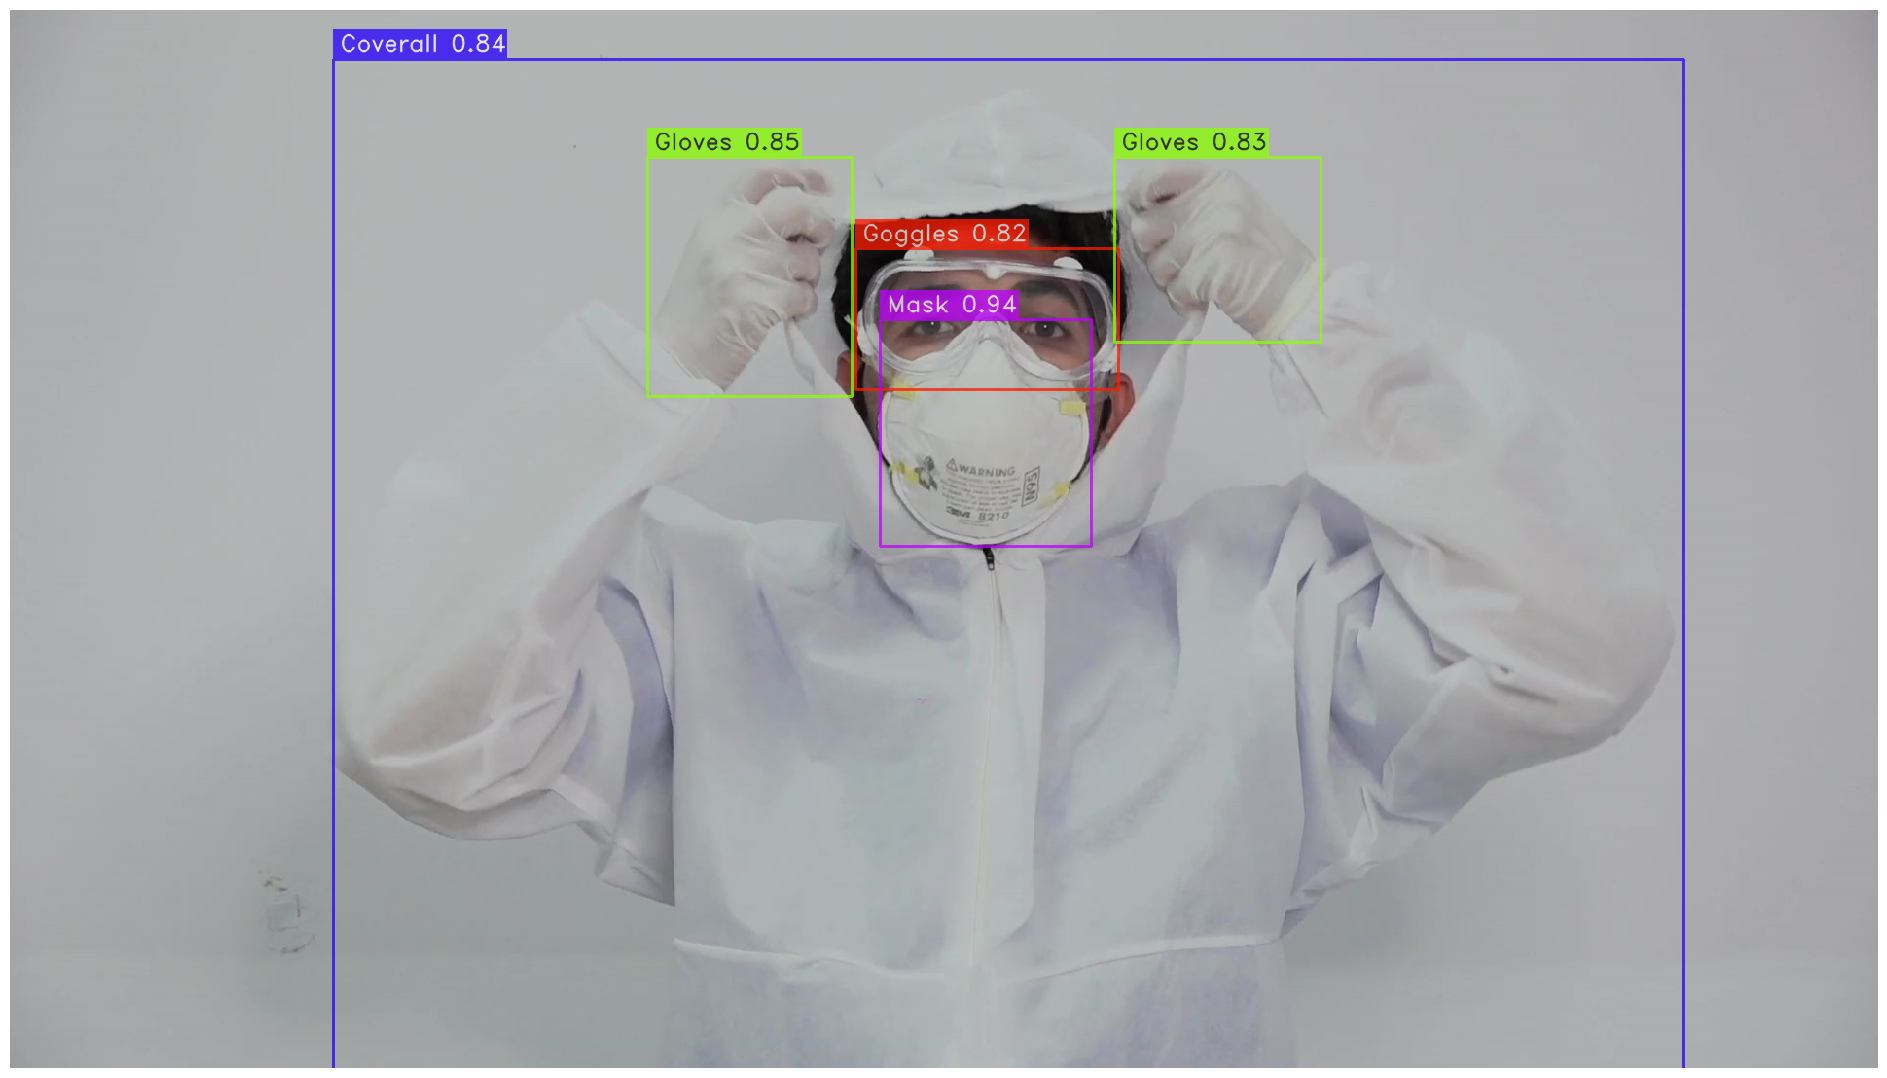

In [10]:
prediction = model.predict(dataset["test"][0]["image"], fuse_model=False)
prediction.show()

# Launch quantization-aware training

Since all local variables are lost, we define again `train_params, train_dataset_params, val_dataset_params, train_dataloader_params, val_dataloader_params`.

Next, we call `modify_params_for_qat`, which will manipulate these configurations according to some best practices for QAT. For example, we turn off augmentations for the trainset. Alll manipulations being done are printed to the screen the for the user's notice.

Finally, after we instantiate our objects with our modified configurations, we call `trainer.qat(model=net, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader, calib_loader=train_loader)`

Under the hood, the following will occur:
- We will use our `calib_loader` which is set to `train_loader` for calibration, gathering statistics that are used to map our network into Int8 range. This part is what we refer to as "Post-training quantization".
- Next, we validate our PTQ model and export it to ONNX format. 
- The exported PTQ model is saved under our checkpoints directory.
- Finally, we perform quantization aware training with our adapted training parameters - since we originally trained for 10 epochs, the general rule of thumb suggests that we quantization-aware train for 10/10=1 epoch. Again, we export the ONNX model to the checkpoints directory.

In [11]:
import os
from super_gradients.common.object_names import Models
from super_gradients.training import models
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.pre_launch_callbacks import modify_params_for_qat

qat_model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))

qat_train_params, qat_train_dataset_params, qat_valid_dataset_params, qat_train_dataloader_params, qat_val_dataloader_params = modify_params_for_qat(
    train_params, train_dataset_params, valid_dataset_params, train_dataloader_params, val_dataloader_params
)

qat_trainset = COCOFormatDetectionDataset(**qat_train_dataset_params)
qat_valset = COCOFormatDetectionDataset(**qat_valid_dataset_params)

qat_train_loader = DataLoader(qat_trainset, **qat_train_dataloader_params)
qat_valid_loader = DataLoader(qat_valset, **qat_val_dataloader_params)

qat_trainer = Trainer(experiment_name="yolo_nas_s_cppe-5_qat", ckpt_root_dir="experiments")
qat_trainer.qat(model=qat_model, training_params=qat_train_params, train_loader=qat_train_loader, valid_loader=qat_valid_loader, calib_loader=qat_train_loader)

[2023-11-21 09:41:59] INFO - checkpoint_utils.py - Successfully loaded model weights from experiments\yolo_nas_s_cppe-5\RUN_20231121_092640_423379\ckpt_best.pth EMA checkpoint.
[2023-11-21 09:41:59] WARNING - pre_launch_callbacks.py - New number of epochs: 3
[2023-11-21 09:41:59] WARNING - pre_launch_callbacks.py - New learning rate: 5e-06
[2023-11-21 09:41:59] WARNING - pre_launch_callbacks.py - New weight decay: 1.0000000000000002e-06
[2023-11-21 09:41:59] WARNING - pre_launch_callbacks.py - lr_mode will be set to cosine for QAT run instead of CosineLRScheduler with cosine_final_lr_ratio=0.01
[2023-11-21 09:41:59] WARNING - pre_launch_callbacks.py - New lr_warmup_epochs: 1
[2023-11-21 09:41:59] WARNING - pre_launch_callbacks.py - EMA will be disabled for QAT run.
[2023-11-21 09:41:59] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:   0%|          | 

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Indexing dataset annotations: 100%|██████████| 1000/1000 [00:00<00:00, 3216.83it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


[2023-11-21 09:42:00] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 29/29 [00:00<00:00, 2316.46it/s]
[2023-11-21 09:42:00] INFO - sg_trainer.py - Using default quantization params: {'ptq_only': False, 'selective_quantizer_params': {'calibrator_w': 'max', 'calibrator_i': 'histogram', 'per_channel': True, 'learn_amax': False, 'skip_modules': None}, 'calib_params': {'histogram_calib_method': 'percentile', 'percentile': 99.99, 'num_calib_batches': None, 'verbose': False}}
[2023-11-21 09:42:03] INFO - sg_trainer.py - Calibrating model...
100%|██████████| 62/62 [00:50<00:00,  1.22it/s]
[2023-11-21 09:43:37] INFO - sg_trainer.py - Validating PTQ model...
Testing: 100%|██████████| 1/1 [00:18<00:00, 18.94s/it]
[2023-11-21 09:43:56] INFO - sg_trainer.py - PTQ Model Validation Results
   - Precision@0.50: 0.134771466255188
   - Recall@0.50: 0.

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================


C:\Users\ekhve\.conda\envs\sg\lib\site-packages\torch\onnx\symbolic_opset9.py:5589: UserWarning: Exporting aten::index operator of advanced indexing in opset 14 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================


[2023-11-21 09:44:15] INFO - sg_trainer.py - Model exported successfully to experiments\yolo_nas_s_cppe-5_qat\yolo_nas_s_cppe-5_qat_1x3x640x640_ptq.onnx
Model expects input image of shape [1, 3, 640, 640]
Input image dtype is torch.float32
Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.65
    confidence_threshold=0.5
    output_predictions_format=batch

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("experiments\yolo_nas_s_cppe-5_qat\yolo_nas_s_cppe-5_qat_1x3x640x640_ptq.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    inputs = [o.name for o in session.get_inputs()]
    outputs = [o.name for o in session.get_outputs()]
    example_input_image = np.zeros((1, 3, 640

The console stream is now moved to experiments\yolo_nas_s_cppe-5_qat\RUN_20231121_094415_049567/console_Nov21_09_44_15.txt


[2023-11-21 09:44:15] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1000       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         62         (len(train_loader))
    - Gradient updates per epoch:   62         (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (12.15M parameters, 12.15M optimized)
    - Learning Rates and Weight Decays:
      - default: (12.15M parameters). LR: 5e-06 (12.15M parameters) WD: 0.0, (29.61K parameters), WD: 1.0000000000000002e-06, (12.12M parameters)

[2023-11-21 09:44:15] INFO - sg_trainer.py - Started

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8027
│   ├── Ppyoloeloss/loss_iou = 0.4381
│   ├── Ppyoloeloss/loss_dfl = 0.5008
│   └── Ppyoloeloss/loss = 1.7416
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7541
    ├── Ppyoloeloss/loss_iou = 0.3891
    ├── Ppyoloeloss/loss_dfl = 0.4383
    ├── Ppyoloeloss/loss = 1.5815
    ├── Precision@0.50 = 0.1197
    ├── Recall@0.50 = 0.9655
    ├── Map@0.50 = 0.9022
    ├── F1@0.50 = 0.2094
    ├── Ap@0.50_coverall = 0.9338
    ├── Ap@0.50_face_shield = 0.9967
    ├── Ap@0.50_gloves = 0.8387
    ├── Ap@0.50_goggles = 0.8405
    └── Ap@0.50_mask = 0.9015



Validating epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7927
│   │   ├── Epoch N-1      = 0.8027 (↘ -0.01)
│   │   └── Best until now = 0.8027 (↘ -0.01)
│   ├── Ppyoloeloss/loss_iou = 0.4327
│   │   ├── Epoch N-1      = 0.4381 (↘ -0.0054)
│   │   └── Best until now = 0.4381 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.5032
│   │   ├── Epoch N-1      = 0.5008 (↗ 0.0024)
│   │   └── Best until now = 0.5008 (↗ 0.0024)
│   └── Ppyoloeloss/loss = 1.7285
│       ├── Epoch N-1      = 1.7416 (↘ -0.013)
│       └── Best until now = 1.7416 (↘ -0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7636
    │   ├── Epoch N-1      = 0.7541 (↗ 0.0095)
    │   └── Best until now = 0.7541 (↗ 0.0095)
    ├── Ppyoloeloss/loss_iou = 0.3919
    │   ├── Epoch N-1      = 0.3891 (↗ 0.0027)
    │   └── Best until now = 0.3891 (↗ 0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.4413
    │   ├── Epoch N-1      = 0.4383 (↗ 0.003)
    │   └── Best until now = 0.4383 (↗ 0.003)
    ├── Ppyoloeloss/loss = 1.5968
    

Validating epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7891
│   │   ├── Epoch N-1      = 0.7927 (↘ -0.0036)
│   │   └── Best until now = 0.7927 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.4366
│   │   ├── Epoch N-1      = 0.4327 (↗ 0.004)
│   │   └── Best until now = 0.4327 (↗ 0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.4996
│   │   ├── Epoch N-1      = 0.5032 (↘ -0.0036)
│   │   └── Best until now = 0.5008 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.7253
│       ├── Epoch N-1      = 1.7285 (↘ -0.0032)
│       └── Best until now = 1.7285 (↘ -0.0032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7572
    │   ├── Epoch N-1      = 0.7636 (↘ -0.0064)
    │   └── Best until now = 0.7541 (↗ 0.0031)
    ├── Ppyoloeloss/loss_iou = 0.3906
    │   ├── Epoch N-1      = 0.3919 (↘ -0.0012)
    │   └── Best until now = 0.3891 (↗ 0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.4404
    │   ├── Epoch N-1      = 0.4413 (↘ -0.0009)
    │   └── Best until now = 0.4383 (↗ 0.0021)
    ├── Ppyoloeloss/loss = 1.

[2023-11-21 09:45:48] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
[2023-11-21 09:45:49] WARNING - tensor_quantizer.py - backbone.stem.conv.rbr_reparam._input_quantizer: Overwriting amax.
[2023-11-21 09:45:49] WARNING - tensor_quantizer.py - backbone.stem.conv.rbr_reparam._weight_quantizer: Overwriting amax.
[2023-11-21 09:45:49] WARNING - tensor_quantizer.py - backbone.stage1.downsample.rbr_reparam._input_quantizer: Overwriting amax.
[2023-11-21 09:45:49] WARNING - tensor_quantizer.py - backbone.stage1.downsample.rbr_reparam._weight_quantizer: Overwriting amax.
[2023-11-21 09:45:49] WARNING - tensor_quantizer.py - backbone.stage1.blocks.conv1.conv._input_quantizer: Overwriting amax.
[2023-11-21 09:45:49] WARNING - tensor_quantizer.py - backbone.stage1.blocks.conv1.conv._weight_quantizer: Overwriting amax.
[2023-11-21 09:45:49] WARNING - tensor_quantizer.py - backbone.stage1.blocks.conv2.conv._input_quantizer: Overwriting amax.
[2023-11-21 09:45:49] WARNING -

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================


### Validate the QAT model

In [12]:
qat_metrics = qat_trainer.test(
    model=qat_model,
    test_loader=valid_loader,
    test_metrics_list=[
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=NUM_CLASSES,
            normalize_targets=True,
            include_classwise_ap=True,
            class_names=CLASS_NAMES,
            post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300, nms_threshold=0.7),
        )
    ],
)
qat_metrics

[2023-11-21 09:46:14] INFO - sg_trainer.py - Exported QAT ONNX to experiments\yolo_nas_s_cppe-5_qat\RUN_20231121_094415_049567\yolo_nas_s_cppe-5_qat_29x3x640x640_qat.onnx
Testing:   0%|          | 0/1 [00:00<?, ?it/s]

{'PPYoloELoss/loss_cls': 0.7572187,
 'PPYoloELoss/loss_iou': 0.39063993,
 'PPYoloELoss/loss_dfl': 0.44040883,
 'PPYoloELoss/loss': 1.5882674,
 'Precision@0.50': 0.13514897227287292,
 'Recall@0.50': 0.9545561671257019,
 'mAP@0.50': 0.8992428779602051,
 'F1@0.50': 0.2324874848127365,
 'AP@0.50_Coverall': 0.9383636116981506,
 'AP@0.50_Face_Shield': 1.0,
 'AP@0.50_Gloves': 0.8325718641281128,
 'AP@0.50_Goggles': 0.8285908699035645,
 'AP@0.50_Mask': 0.8966881036758423}

Testing: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


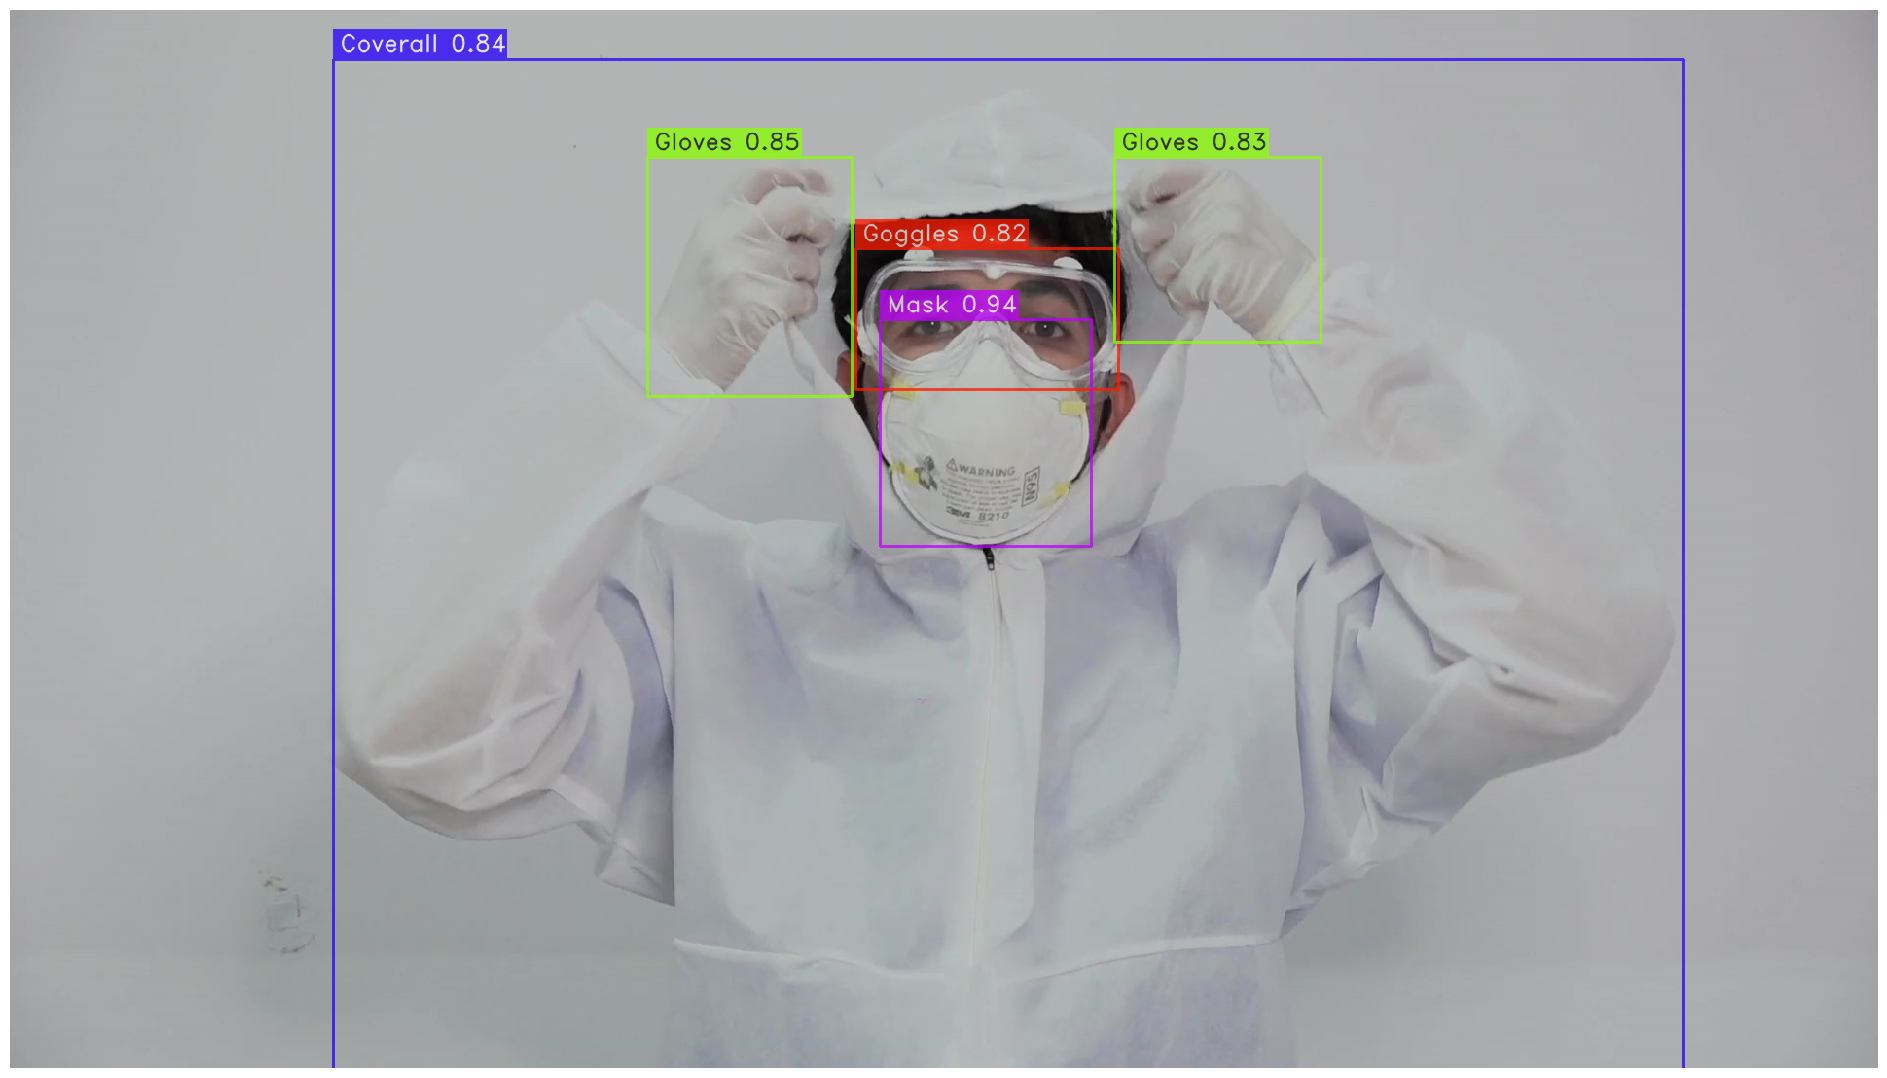

In [13]:
prediction = model.predict(dataset["test"][0]["image"], fuse_model=False)
prediction.show()

Let's compare the metrics of the regular model, after PTQ and after QAT.    

In [14]:
from collections import defaultdict
import pandas as pd
results = defaultdict(list)

for metric_name, metric_value in qat_metrics.items():
    if "loss" in metric_name:
        continue     
    results["Metric"].append(metric_name)
    results["Regular"].append(regular_metrics[metric_name])
    results["After QAT"].append(qat_metrics[metric_name])
    results["Delta"].append(qat_metrics[metric_name] - regular_metrics[metric_name])

pd.DataFrame(results)

,Metric,Regular,After QAT,Delta
0,Precision@0.50,0.136825,0.135149,-0.001676
1,Recall@0.50,0.948874,0.954556,0.005683
2,mAP@0.50,0.889733,0.899243,0.009509
3,F1@0.50,0.234702,0.232487,-0.002214
4,AP@0.50_Coverall,0.926071,0.938364,0.012293
5,AP@0.50_Face_Shield,1.000000,1.000000,0.000000
6,AP@0.50_Gloves,0.826198,0.832572,0.006374
7,AP@0.50_Goggles,0.797043,0.828591,0.031547
8,AP@0.50_Mask,0.899355,0.896688,-0.002667


As you can see from the table above, after QAT, the model's performance is slightly better than the regular model.

# Summary

And there we have it! Our PTQ and QAT checkpoints have been exported to our checkpoints directory under `yolo_nas_s_cppe-5_qat` folder.

If we plug them into [netron](https://netron.app), we can see that new blocks that were not a part of the original network were introduced: the **Quantize/Dequantize** layers -

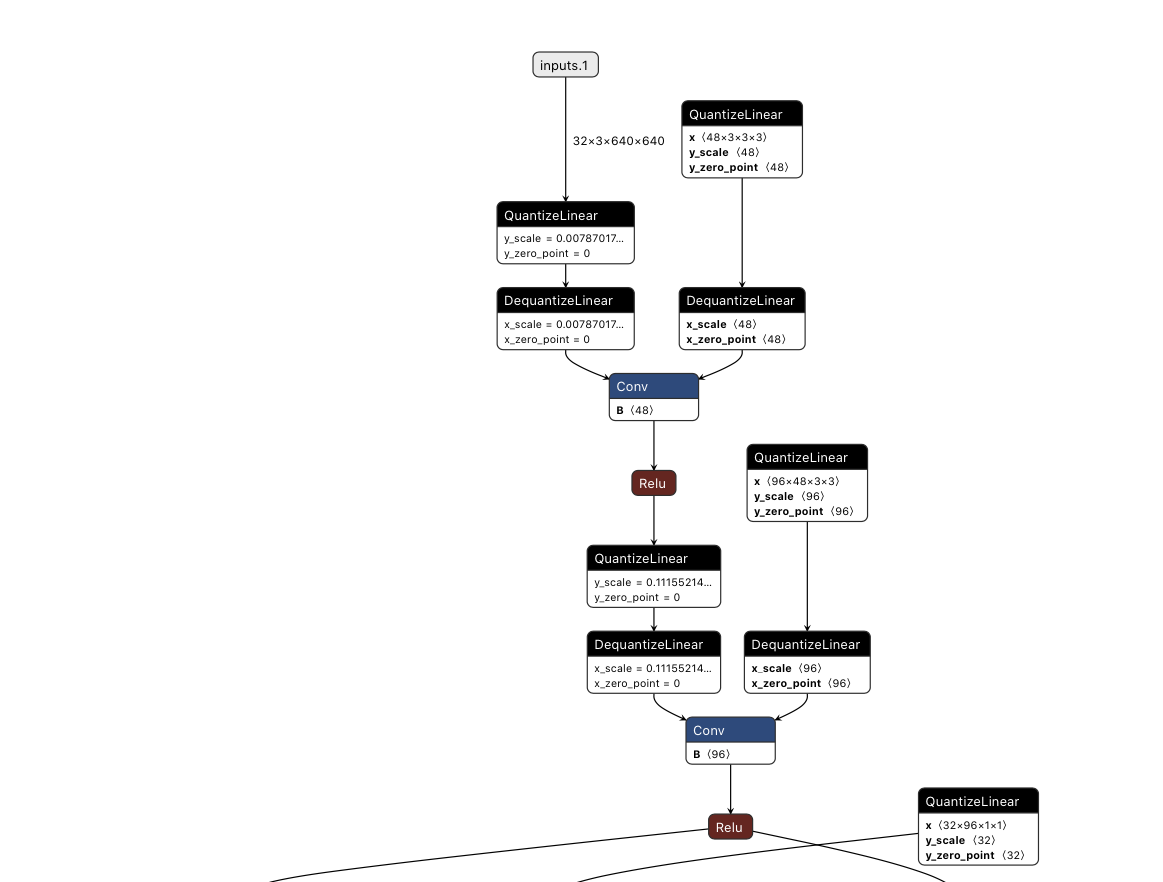

This is expected and a good way to verify that our model is ready to be converted to Int8 using Nvidia's [TesnorRT](https://docs.nvidia.com/deeplearning/tensorrt/quick-start-guide/index.html#deploy-engine):
 We can now use these ONNX files to deploy our newly trained YoloNAS models to production. When building the TRT engine it is important specify that we convert to Int8 (the fake quantized layers in our models will be adapted accordingly), this can be done by running:
`trtexec --fp16 --int8 --onnx=your_yolonas_qat_model.onnx`.

For more information on how to properly export and benchmark YoloNAS, click [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/BenchmarkingYoloNAS.md).